# Exploring CMH Parking Violations

## Imports

* pandas

In [2]:
#%matplotlib inline
#import numpy as np

import pandas as pd
import osmnx as ox
#import matplotlib.pyplot as plt

### Loading data

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,) This dataset covers years 2013 through 2018.

In [3]:
parking = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz", compression = 'gzip')

/Users/ovi/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,21,25,43,78,91,97) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.set_option('display.max_columns', None)
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 98 columns):
nix dt        745821 non-null int64
hrg offcr     27951 non-null object
dispo         745821 non-null int64
badge         733375 non-null object
susp til      745821 non-null int64
mail1 dt      745821 non-null int64
iss dt        745821 non-null int64
ent due       745821 non-null object
viol          745821 non-null int64
ipp no        745821 non-null int64
mail2 dt      745821 non-null int64
conf dt2      745821 non-null int64
fine          745821 non-null object
coll dt       745821 non-null int64
pen4          745821 non-null object
corro         745821 non-null int64
last seiz     745821 non-null int64
hear proc     745821 non-null int64
dis dt        745821 non-null int64
mail1 pdt     745821 non-null int64
bootbl ct     745821 non-null int64
ticket        745821 non-null object
entity        745821 non-null int64
plea          0 non-null float64
multno        745821 no

In [5]:
dictionary = pd.read_json("https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")


# pd.set_option('display.max_colwidth', -1)
dictionary


,type,name,description
0,integer,ENTITY,Unique system-generated number to identify lic...
1,integer,TERMDT,If a license plate was on a fleet and terminat...
2,integer,MULTNO,"If a license plate was on a fleet, that fleet ..."
3,string,ENT DUE,Total amount due on the entity
4,string,ENT OVP,Overpaid amount on the entity
...,...,...,...
93,integer,LAT,Latitude of handheld issuing device when ticke...
94,integer,LONG,Longitude of handheld issuing device when tick...
95,integer,OPEN CT,Number of open (unpaid) tickets on the entity
96,integer,IPP NO,Installment Payment Plan number


In [6]:
G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive')

In [7]:
type(G)
# can we cache this? it takes forever to download..

networkx.classes.multidigraph.MultiDiGraph

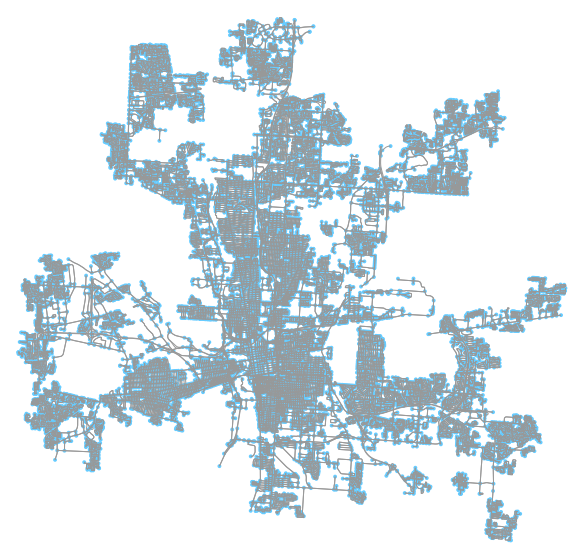

(<Figure size 984.789x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129b57950>)

In [8]:
ox.plot_graph(G, fig_height=10)


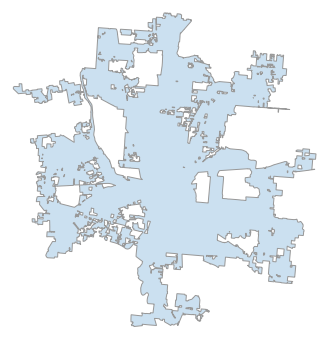

In [9]:

city = ox.gdf_from_place('Columbus, Ohio')
Gs = ox.plot_shape(ox.project_gdf(city))

cmh_boundaries = ox.project_gdf(city)
cmh_n = cmh_boundaries.bbox_north[0]
cmh_s = cmh_boundaries.bbox_south[0]
cmh_e = cmh_boundaries.bbox_east[0]
cmh_w = cmh_boundaries.bbox_west[0]

In [10]:
parking['lat_float'] = parking['lat'] / 1000000
parking['long_float'] = parking['long'] / 1000000 * -1

In [11]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")

meters.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [22]:
#meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns = {'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [30]:
parking_loc = parking[['meter', 'lat_float', 'long_float']]
parking_loc = parking_loc.rename(columns = { 'meter': 'Meter'})

meters_loc = meters[['Meter', 'Lat', 'Long']]

parking_x_meters = parking_loc.merge(meters_loc, how = 'left', on = 'Meter')

parking_x_meters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745821 entries, 0 to 745820
Data columns (total 5 columns):
Meter         418804 non-null object
lat_float     745821 non-null float64
long_float    745821 non-null float64
Lat           412790 non-null float64
Long          412790 non-null float64
dtypes: float64(4), object(1)
memory usage: 34.1+ MB


In [31]:
parking_x_meters[parking_meters_loc['lat_float'] > 1]

,Meter,lat_float,long_float,Lat,Long
103,NaN,39.993781,-83.009826,NaN,NaN
104,NaN,39.990245,-83.010749,NaN,NaN
106,EG575,39.959337,-82.988080,39.958880,-82.986890
107,EG549,39.959065,-82.988206,39.958760,-82.987910
108,NaN,39.946902,-82.995049,NaN,NaN
...,...,...,...,...,...
745651,K239,39.978855,-83.004537,39.978660,-83.004459
745662,EX32,39.977493,-83.009742,39.969239,-82.999374
745665,EA30,39.953717,-82.996813,39.953806,-82.996640
745677,NaN,39.952129,-82.995637,NaN,NaN


In [32]:
print (cmh_n, cmh_s, cmh_e, cmh_w)
fudge = 0.2
infraction_locations = parking[(parking['lat_float']  > cmh_s - fudge) &
                               (parking['lat_float']  < cmh_n + fudge) &
                               (parking['long_float'] > cmh_w - fudge) &
                               (parking['long_float'] < cmh_e + fudge) 
                              ]
print(infraction_locations[['lat_float', 'long_float']].shape[0] / parking.shape[0])



40.157272 39.8086936 -82.7713119 -83.2101797
0.04329054826828421


In [34]:
#parking_x_meters
infraction_locations_from_meters =  parking_x_meters[(
     (parking_x_meters['Lat']  > cmh_s - fudge) &
     (parking_x_meters['Lat']  < cmh_n + fudge) &
     (parking_x_meters['Long'] > cmh_w - fudge) &
     (parking_x_meters['Long'] < cmh_e + fudge)) |
    ((parking['lat_float']  > cmh_s - fudge) &
     (parking['lat_float']  < cmh_n + fudge) &
     (parking['long_float'] > cmh_w - fudge) &
     (parking['long_float'] < cmh_e + fudge))
                    ]
print(infraction_locations_from_meters[['lat_float', 'long_float']].shape[0] / parking.shape[0])


0.5674538528681815


In [36]:
infraction_locations_from_meters[infraction_locations_from_meters['lat_float'] > cmh_s - fudge][['lat_float', 'long_float', 'Lat', 'Long']]

,lat_float,long_float,Lat,Long
103,39.993781,-83.009826,NaN,NaN
104,39.990245,-83.010749,NaN,NaN
106,39.959337,-82.988080,39.958880,-82.986890
107,39.959065,-82.988206,39.958760,-82.987910
108,39.946902,-82.995049,NaN,NaN
...,...,...,...,...
745651,39.978855,-83.004537,39.978660,-83.004459
745662,39.977493,-83.009742,39.969239,-82.999374
745665,39.953717,-82.996813,39.953806,-82.996640
745677,39.952129,-82.995637,NaN,NaN
